In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

### Generate

In [2]:
ratio_table = np.empty((3, 4, 32), dtype=object) # 3 cases, 4 sessions, 32 channels

case_title = 'Fix'
case = 'all'
fs = 1200
tmax = 1.5
watch = '1 fixation'
tmin = 0 # include fix or not?

highpass = None
lowpass = None

sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)

interval = [0, 1.5]
t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
sessions = [sb, sa, rb, ra]

for channel in range(32):
        for i, session in enumerate(sessions):
            ratios = np.empty(())
            data = session[channel]
            psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
            bp_theta = fe.band_power(psds, freqs, [4, 8])
            bp_gamma = fe.band_power(psds, freqs, [30, 50])
            ratio = bp_theta/bp_gamma
            ratios = np.append(ratios, ratio)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            ratio_table[0, i, channel] = ratios

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


In [3]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

for channel in range(32):
    for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            ratios = np.empty(())
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                bp_theta = fe.band_power(psds, freqs, [4, 8])
                bp_gamma = fe.band_power(psds, freqs, [30, 50])
                ratio = bp_theta/bp_gamma
                ratios = np.append(ratios, ratio)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            ratio_table[1, i, channel] = ratios

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

In [4]:
case_title = 'exo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

for channel in range(32):
    for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            ratios = np.empty(())
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                bp_theta = fe.band_power(psds, freqs, [4, 8])
                bp_gamma = fe.band_power(psds, freqs, [30, 50])
                ratio = bp_theta/bp_gamma
                ratios = np.append(ratios, ratio)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            ratio_table[2, i, channel] = ratios

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

### Analysis

NameError: name 'dfa_subtracts' is not defined

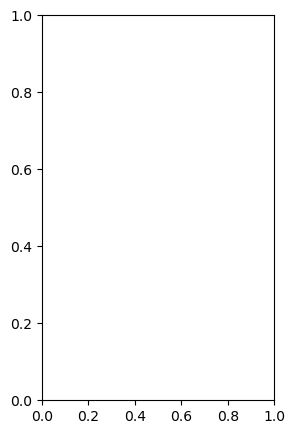

In [5]:
channels = [24, 25, 26, 28]
sham_before = ratio_table[:, 0, channels]
sham_after = ratio_table[:, 1, channels]
real_before = ratio_table[:, 2, channels]
real_after = ratio_table[:, 3, channels]

# Set up the figure and axes
case_names = ['Fixation', 'Endo', 'Exo']



# for band, band_name in enumerate(band_names):

fig, ax = plt.subplots(figsize=(3, 5))
# ax = axes[band]
# sham power increase
sham = dfa_subtracts[0,channels,:]
sham_ses = se_subtracts[0,channels,:]
sham_mean_grand, sham_ses_grand  = calculate_grand_mean_and_se(sham, sham_ses, num_subtracts[0,channels,:])
ax.errorbar(case_names, sham_mean_grand, yerr=sham_ses_grand, color='blue', label='Sham increase', marker='o', linestyle='-')

real = dfa_subtracts[1,channels,:]
real_ses = se_subtracts[1,channels,:]
real_mean_grand, real_ses_grand  = calculate_grand_mean_and_se(real, real_ses, num_subtracts[1,channels,:])
ax.errorbar(case_names, real_mean_grand, yerr=real_ses_grand, color='red', label='Real increase', marker='o', linestyle='-')


ax.axhline(y=0, color='black', linestyle='--')
ax.set_ylim([-0.04, 0.09])
ax.set_xlabel('Trial type')
ax.set_ylabel('Change of $\u03B1$')
# ax.set_title(band_name)

    # if band == 0:
    #     ax.set_ylabel('Band power increase')
    # else:
    #     ax.set_ylabel('')  # Clear the y-axis label

# plt.subplots_adjust(wspace=0.3)
# fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
plt.show()